# Exploration EDA - Data Classification

### Importation des librairies

In [53]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

## Définition du chemin et premier chargement des données

In [54]:
root_road = Path("../raw_data/classification")
data = []

for training_or_testing in ["Training", "Testing"]:
    path = root_road/training_or_testing
    for class_road in path.iterdir():
        if class_road.is_dir():
            tumor = class_road.name
            for image in class_road.glob("*.jpg"):
                data.append({
                    "path": str(image),
                    "train_or_test": training_or_testing,
                    "type_of_tumor": tumor
                })
df = pd.DataFrame(data)

print("--- DataFrame ---")
print(df.head())

print(f"\nNombre total d'images: {len(df)}")
print(f"\nEnsembles disponibles: {df['train_or_test'].unique()}")

--- DataFrame ---
                                                path train_or_test  \
0  ../raw_data/classification/Training/pituitary/...      Training   
1  ../raw_data/classification/Training/pituitary/...      Training   
2  ../raw_data/classification/Training/pituitary/...      Training   
3  ../raw_data/classification/Training/pituitary/...      Training   
4  ../raw_data/classification/Training/pituitary/...      Training   

  type_of_tumor  
0     pituitary  
1     pituitary  
2     pituitary  
3     pituitary  
4     pituitary  

Nombre total d'images: 7023

Ensembles disponibles: ['Training' 'Testing']


## EDA des données

### Équilibre des données


--- Distribution des classes (Total) ---
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: type_of_tumor, dtype: int64

--- Distribution des classes par Ensemble ---
type_of_tumor  glioma  meningioma  notumor  pituitary
train_or_test                                        
Testing           300         306      405        300
Training         1321        1339     1595       1457


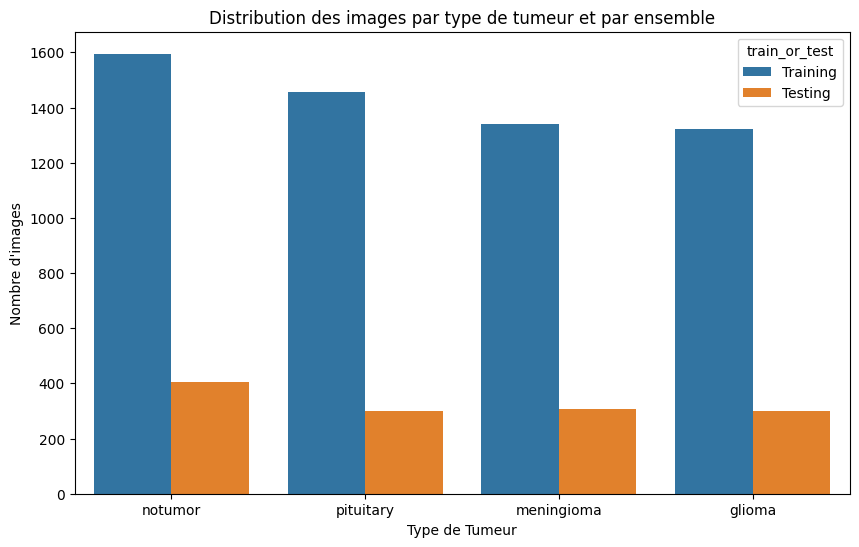

In [56]:
# Analyse de l'équilibre des classes
print("\n--- Distribution des classes (Total) ---")
print(df['type_of_tumor'].value_counts())

# Analyse par ensemble (Training/Testing)
print("\n--- Distribution des classes par Ensemble ---")
print(df.groupby('train_or_test')['type_of_tumor'].value_counts().unstack(fill_value=0))

# Visualisation de la distribution des classes
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x='type_of_tumor',
    hue='train_or_test',
    order=df['type_of_tumor'].value_counts().index # Trier par effectif
)
plt.title("Distribution des images par type de tumeur et par ensemble")
plt.xlabel("Type de Tumeur")
plt.ylabel("Nombre d'images")
plt.show()

### Évaluation des splits ratio

In [ ]:
total_count = len(df)

set_counts = df['train_or_test'].value_counts()
set_ratio = set_counts / total_count * 100

print("\n--- Split Ratio | Training - Testing ---")
print(set_counts.to_string())
print('-'*39)
print(set_ratio.round(2).to_string(header=False)," %")


--- Split Ratio | Training - Testing ---
Training    5712
Testing     1311
---------------------------------------
Training    81.33
Testing     18.67  %


### Distribution des sizes d'images dans les données

In [82]:
df_sample = df.sample(n=min(500, len(df)), random_state=42)

# Listes pour stocker les propriétés
img_properties = []

print("--- 3. Analyse des propriétés des images (Échantillon de 500) ---")

for index, row in df_sample.iterrows():
    img = Image.open(row['path'])
    width, height = img.size
    channels = len(img.getbands())

    img_properties.append({
        "width": width,
        "height": height,
        "channels": channels
    })

df_props = pd.DataFrame(img_properties)

--- 3. Analyse des propriétés des images (Échantillon de 500) ---



Répartition des Canaux de Couleur :
3    283
1    217

Statistiques sur les Dimensions :
Taille la plus fréquente (Largeur x Hauteur) :
width  height
512    512       342
225    225        20
630    630        12
236    236         6
300    168         6


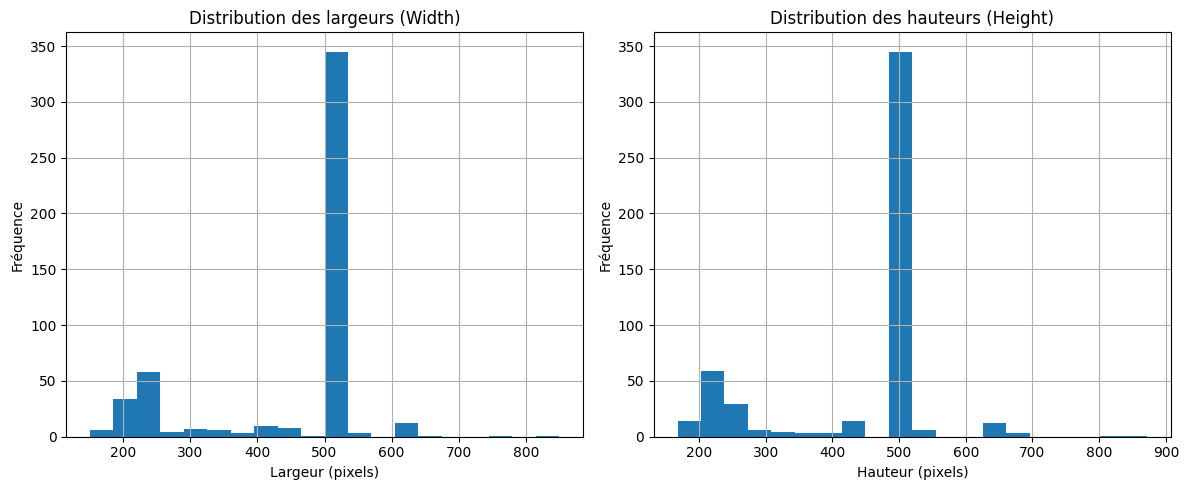

In [83]:
print("\nRépartition des Canaux de Couleur :")
print(df_props['channels'].value_counts().to_string())

print("\nStatistiques sur les Dimensions :")
print(f"Taille la plus fréquente (Largeur x Hauteur) :")

# Afficher les 5 tailles les plus courantes
most_common_size = df_props.groupby(['width', 'height']).size().sort_values(ascending=False).head()
print(most_common_size.to_string())

# Visualisation (Optionnelle mais recommandée)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_props['width'].hist(bins=20)
plt.title("Distribution des largeurs (Width)")
plt.xlabel("Largeur (pixels)")
plt.ylabel("Fréquence")

plt.subplot(1, 2, 2)
df_props['height'].hist(bins=20)
plt.title("Distribution des hauteurs (Height)")
plt.xlabel("Hauteur (pixels)")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

### Visualisation d'images par type de tumeur


--- 4. Visualisation d'un Échantillon par type de tumeur ---


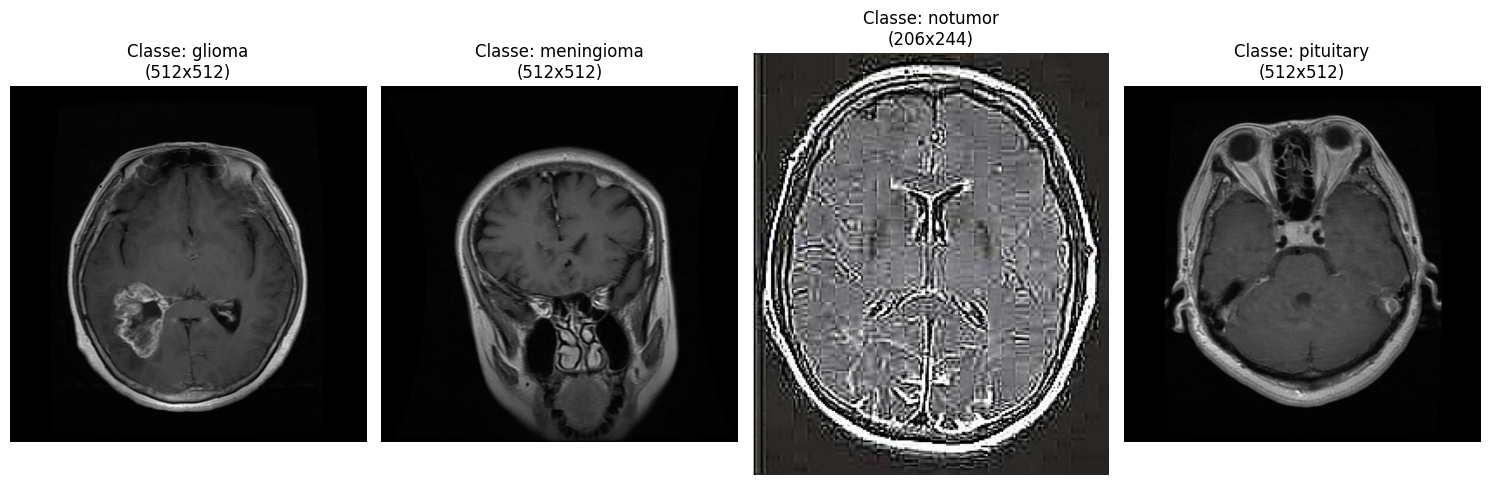

In [76]:
print("\n--- 4. Visualisation d'un Échantillon par type de tumeur ---")

# Obtenir un échantillon unique pour chaque classe
sample_classes = df.groupby('type_of_tumor').first()
classes = sample_classes.index.tolist()

plt.figure(figsize=(15, 5))

for i, class_name in enumerate(classes):
    # Chemin de l'image
    file_path = sample_classes.loc[class_name, 'path']

    try:
        # Charger l'image
        img = Image.open(file_path).convert('RGB')

        # Afficher l'image
        plt.subplot(1, len(classes), i + 1)
        plt.imshow(img)
        plt.title(f"Classe: {class_name}\n({img.size[0]}x{img.size[1]})")
        plt.axis('off')

    except Exception as e:
        print(f"Impossible d'afficher l'image pour {class_name}: {e}")

plt.tight_layout()
plt.show()


--- 5. Analyse de la Distribution des Pixels ---
Valeur de pixel minimale: 0
Valeur de pixel maximale: 255


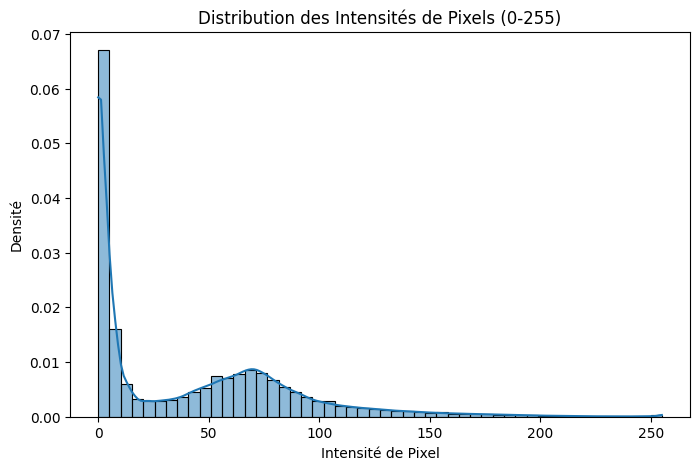

In [78]:
pixel_values = []

# Charger un échantillon de 100 images pour des raisons de rapidité
df_pixel_sample = df.sample(n=min(100, len(df)), random_state=42)

print("\n--- 5. Analyse de la Distribution des Pixels ---")

for index, row in df_pixel_sample.iterrows():
    # Charger l'image, la convertir en RGB et en tableau NumPy
    img_array = np.array(Image.open(row['path']).convert('RGB'))

    # Aplatir le tableau pour obtenir une liste de toutes les valeurs de pixels
    pixel_values.extend(img_array.flatten())

pixel_values = np.array(pixel_values)

print(f"Valeur de pixel minimale: {pixel_values.min()}")
print(f"Valeur de pixel maximale: {pixel_values.max()}")

# Visualisation de la distribution des pixels
plt.figure(figsize=(8, 5))
sns.histplot(pixel_values, bins=50, kde=True, stat='density')
plt.title("Distribution des Intensités de Pixels (0-255)")
plt.xlabel("Intensité de Pixel")
plt.ylabel("Densité")
plt.show()

In [ ]:
path_colonne = 'path'

# Utiliser TOUT le dataset
df_full = df.copy()

channel_analysis = []
total_images = len(df_full)

print(f"--- 3. Analyse des propriétés des images (TOUT LE DATASET : {total_images} images) ---")

for index, row in df_full.iterrows():
    try:
        # Charger l'image
        img = Image.open(row[path_colonne])

        channels = len(img.getbands())
        channel_analysis.append({
            'file_path': row[path_colonne],
            'class': row['train_or_test'],
            'channels': channels
        })
    except Exception as e:
        # Ceci vous donnera l'emplacement de tout fichier corrompu
        print(f"Avertissement: Impossible d'ouvrir le fichier {row[path_colonne]}: {e}")
        continue

df_channels = pd.DataFrame(channel_analysis)

--- 3. Analyse des propriétés des images (TOUT LE DATASET : 7023 images) ---



--- Répartition des Canaux de Couleur dans le Dataset Complet ---
3    3926
1    3094
4       3

Images à 3 canaux (RGB) trouvées : 3926 / 7023 (55.90 %)
Distribution des classes pour les images RGB :
Training    3236
Testing      690


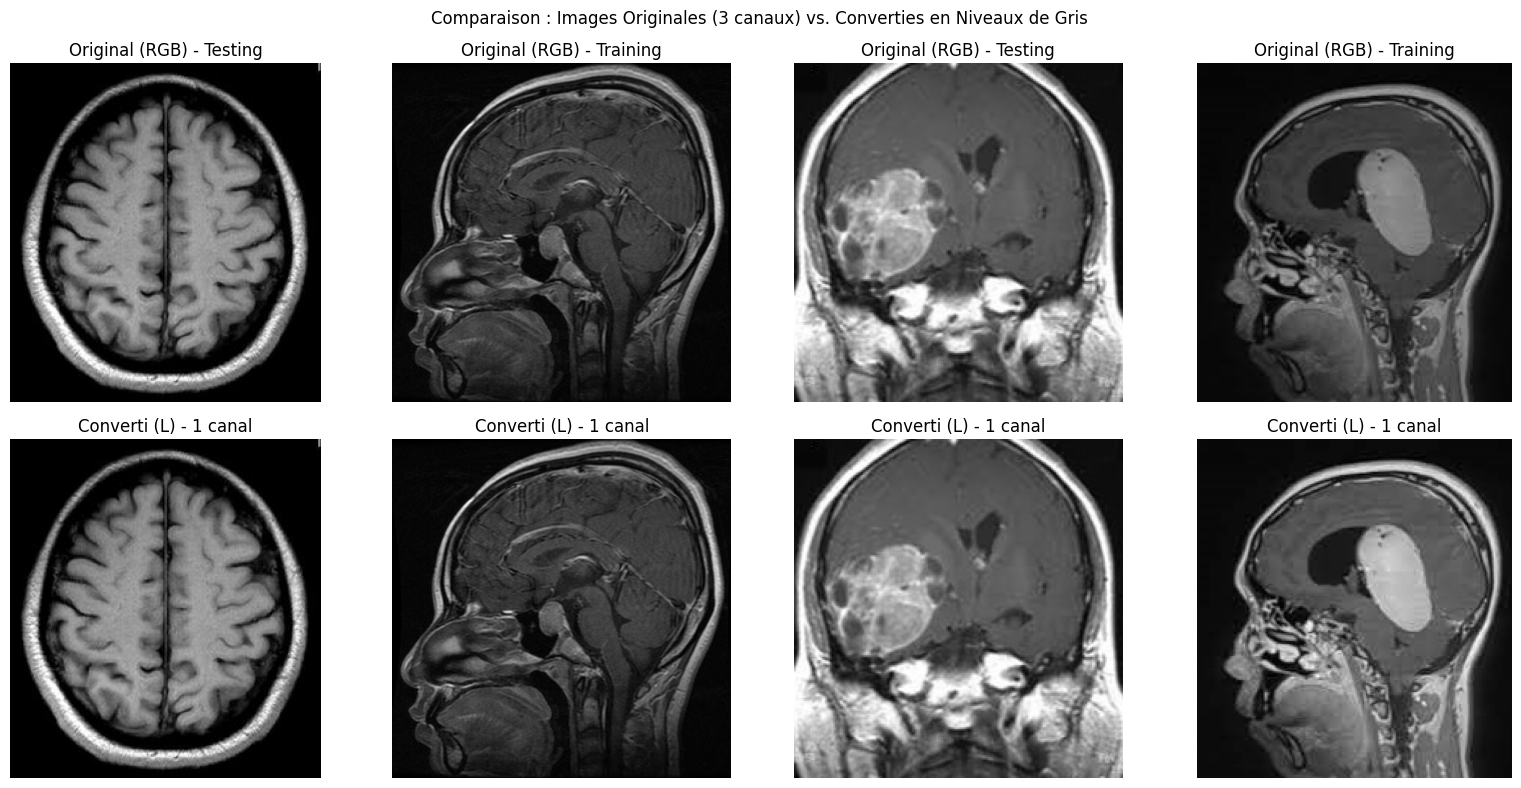

In [81]:
# 1. Diagnostic de la répartition des canaux
print("\n--- Répartition des Canaux de Couleur dans le Dataset Complet ---")
print(df_channels['channels'].value_counts().to_string())

# 2. Identification et Résumé des images à 3 canaux
df_rgb = df_channels[df_channels['channels'] == 3]

if df_rgb.empty:
    print("\nAucune image à 3 canaux trouvée. Toutes sont en niveaux de gris (1 canal).")
else:
    percentage_rgb = len(df_rgb) / total_images * 100
    print(f"\nImages à 3 canaux (RGB) trouvées : {len(df_rgb)} / {total_images} ({percentage_rgb:.2f} %)")
    print("Distribution des classes pour les images RGB :")
    print(df_rgb['class'].value_counts().to_string())

    # La visualisation reste pertinente pour l'inspection
    num_to_show = min(4, len(df_rgb))
    # Nous échantillonnons toujours ici, car nous n'avons pas besoin d'afficher les 2000 images !
    sample_to_show = df_rgb.sample(n=num_to_show, random_state=42)

    plt.figure(figsize=(num_to_show * 4, 8))

    for i, (index, row) in enumerate(sample_to_show.iterrows()):
        file_path = row['file_path']
        img_original = Image.open(file_path)
        img_grayscale = img_original.convert('L')

        plt.subplot(2, num_to_show, i + 1)
        plt.imshow(img_original)
        plt.title(f"Original ({img_original.mode}) - {row['class']}")
        plt.axis('off')

        plt.subplot(2, num_to_show, i + num_to_show + 1)
        plt.imshow(img_grayscale, cmap='gray')
        plt.title(f"Converti (L) - 1 canal")
        plt.axis('off')

    plt.suptitle("Comparaison : Images Originales (3 canaux) vs. Converties en Niveaux de Gris")
    plt.tight_layout()
    plt.show()

In [85]:
import hashlib
import time

# --- Configuration (Assurez-vous que df est chargé) ---

# Utilisez le nom de colonne correct si ce n'est pas 'file_path'
path_colonne = 'path'

# Liste pour stocker le hash et les métadonnées de chaque image
hash_data = []
total_images = len(df)
start_time = time.time()

print(f"--- Démarrage de la vérification de l'unicité du contenu (7023 images) ---")
print("Ceci peut prendre quelques minutes...")

# 1. Calcul du Hash pour chaque image
for index, row in df.iterrows():
    file_path = row[path_colonne]

    try:
        # Charger l'image
        img = Image.open(file_path)

        # IMPORTANT : Normaliser en niveaux de gris ('L') avant de hasher.
        # Cela garantit que les doublons sont détectés même si l'un est en RGB et l'autre en L.
        img_normalized = img.convert('L')

        # Convertir les données de l'image en bytes
        img_bytes = img_normalized.tobytes()

        # Calculer le hash MD5
        img_hash = hashlib.md5(img_bytes).hexdigest()

        hash_data.append({
            'hash': img_hash,
            'file_path': file_path,
            'set': row['type_of_tumor'],
            'class': row['train_or_test']
        })

    except Exception as e:
        print(f"Avertissement: Erreur lors du traitement de {file_path}: {e}")

df_hash = pd.DataFrame(hash_data)
end_time = time.time()
print(f"Hashing terminé en {end_time - start_time:.2f} secondes.")

# 2. Identification des Hashs Dupliqués
duplicate_hashes = df_hash['hash'].value_counts()
duplicate_hashes = duplicate_hashes[duplicate_hashes > 1].index.tolist()

if not duplicate_hashes:
    print("\n✅ Aucune image dupliquée trouvée dans le dataset.")
else:
    print(f"\n❌ {len(duplicate_hashes)} hashs uniques correspondant à des images dupliquées trouvés.")

    # 3. Affichage des Doublons et de la Fuite de Données
    print("\n--- Détail des Doublons et Fuite de Données (Data Leakage) ---")

    # Filtrer le DataFrame pour ne garder que les doublons
    df_duplicates = df_hash[df_hash['hash'].isin(duplicate_hashes)].sort_values(by='hash')

    # Grouper par hash et vérifier la répartition dans les sets (Training/Testing)
    leakage_summary = df_duplicates.groupby('hash')['set'].nunique()
    leakage_count = (leakage_summary > 1).sum()

    if leakage_count > 0:
        print(f"\n⚠️ **Fuite de Données Critique (CRITICAL DATA LEAKAGE)** : {leakage_count} images sont présentes à la fois dans Training ET Testing.")
        print("Il est impératif de supprimer les doublons du set Testing pour avoir une évaluation impartiale.")
    else:
        print("\nNote : Tous les doublons sont confinés à un seul set (soit Training, soit Testing).")

    # Afficher les 10 premières paires de doublons pour inspection
    print("\nExemples des 10 premiers doublons trouvés :")
    print(df_duplicates.head(20).to_string())

# 4. Total des Images Uniques
print(f"\nNombre total d'images uniques (basé sur le contenu): {len(df_hash['hash'].unique())}")
print(f"Nombre total d'images chargées: {total_images}")

--- Démarrage de la vérification de l'unicité du contenu (7023 images) ---
Ceci peut prendre quelques minutes...
Hashing terminé en 6.48 secondes.

❌ 300 hashs uniques correspondant à des images dupliquées trouvés.

--- Détail des Doublons et Fuite de Données (Data Leakage) ---

Note : Tous les doublons sont confinés à un seul set (soit Training, soit Testing).

Exemples des 10 premiers doublons trouvés :
                                  hash                                                      file_path         set     class
6284  00ef654171535b89d19b003ba8a3447b      ../raw_data/classification/Testing/notumor/Te-no_0039.jpg     notumor   Testing
2505  00ef654171535b89d19b003ba8a3447b     ../raw_data/classification/Training/notumor/Tr-no_0124.jpg     notumor  Training
1628  00ef654171535b89d19b003ba8a3447b     ../raw_data/classification/Training/notumor/Tr-no_1094.jpg     notumor  Training
1585  02a30316e2def82956756943ff92da85     ../raw_data/classification/Training/notumor/Tr-no_03